# Lesson 07
# Peter Lorenz

In this assignment, we use support vector machines to identify useful predictors for the age of abalones when data about their number of rings is unavailable.

## 0. Preparation

Import the required libraries:

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Declare utility functions:

Read and prepare the data:

In [5]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv"

# Download the data into a dataframe object
abalone_data = pd.read_csv(url)

# Display shape and initial data
abalone_data.shape
abalone_data.head()

# Examine column types
abalone_data.info()

(4177, 9)

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.514,0.225,0.101,0.150,15
1,M,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7
2,F,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9
3,M,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10
4,I,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole Weight    4177 non-null   float64
 5   Shucked Weight  4177 non-null   float64
 6   Viscera Weight  4177 non-null   float64
 7   Shell Weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


One-hot encode the Sex column:

In [9]:
# Use pandas to one-hot encode categorical variables
abalone_data_enc = pd.get_dummies(abalone_data, columns=['Sex'], drop_first=True)

# Display shape and sample contents
abalone_data_enc.shape
abalone_data_enc.head()

(4177, 10)

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Sex_I,Sex_M
0,0.455,0.365,0.095,0.514,0.225,0.101,0.150,15,0,1
1,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7,0,1
2,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9,0,0
3,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10,0,1
4,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7,1,0


We are now ready to build our model.

## 1. Convert continuous output value to binary and build SVC
In this section we convert the continuous output value (Rings) from continuous to binary (0,1) and build an SVC, with class '0' representing specimens less than 11 years old and '1' representing specimens 11 years old and greater. First, we convert the continuous target variable to binary:

In [24]:
# Convert number of rings to binary using 11+ as the cutoff
is_old = np.array(pd.cut(abalone_data_enc['Rings'], [0, 11, 1000], labels=['0', '1'])).astype(int)
is_old

array([1, 0, 0, ..., 0, 0, 1])

We must determine the relative weight of each class by considering its representation in the total:

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is Older than 10 years old?')]

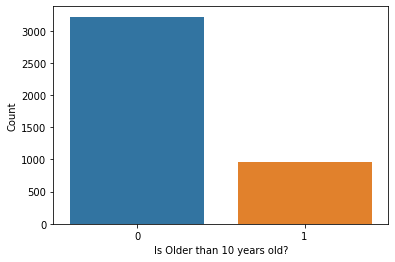

In [31]:
# Plot distribution by output
ax = sns.countplot(x=is_old)
ax.set(xlabel='Is Older than 10 years old?', ylabel='Count')

The population has roughly three times as many members under 11 years old as 11 or older. So we must consider the class weights accordingly below in our models. Fortunately, we can use 'balanced' mode for the class weights, which automatically adjusts the class weights in a manner that is inversely proportional to their frequencies in the input data.

Next we partition the data into training and test sets:

In [29]:
# Model columns
cols = ['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 
        'Shell Weight', 'Sex_I', 'Sex_M']

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(abalone_data_enc[cols], 
                                                    is_old, 
                                                    test_size = 0.1,
                                                    random_state = 0)

# Describe training and test
print("Training data has {} rows.".format(X_train.shape[0]))
print("Test data has {} rows.".format(X_test.shape[0]))

Training data has 3759 rows.
Test data has 418 rows.


Now we build an SVM classifier using the linear kernel:

In [33]:
# Build and fit SVC
svmc = SVC(kernel='linear', class_weight='balanced', cache_size=2048)
svmc.fit(X_train, y_train)

# Get predictions
y_pred = svmc.predict(X_test)

SVC(C=1.0, break_ties=False, cache_size=2048, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

We have build and fit our SVM classifier. Next we examine its performance.

## 2.  Determine percentage of correctly classified results
In this section we determine the percentage of correctly classified results using our best guess for hyperparameters and kernel. We do this by examining the metrics:

array([[261,  52],
       [ 28,  77]], dtype=int64)

              precision    recall  f1-score   support

           0       0.90      0.83      0.87       313
           1       0.60      0.73      0.66       105

    accuracy                           0.81       418
   macro avg       0.75      0.78      0.76       418
weighted avg       0.83      0.81      0.81       418



Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0, 1)

(0, 1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

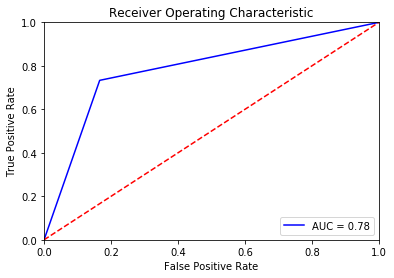

Area under the ROC curve (AUC): 0.7835995740149095


In [37]:
# Display confusion matrix
confusion_matrix(y_test, y_pred)

# Display performance metrics
print(classification_report(y_test, y_pred))

# Compute ROC metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Display ROC plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Display ROC score
print('Area under the ROC curve (AUC):', roc_auc_score(y_test, y_pred))

Our initial simplistic SVM classifier did not do badly, with 0.6 precision, 0.73 recall, and 0.78 under the ROC curve. But there remains room for improvement. We now turn to tuning the hyperparameters to extract better performance if possible.

## 3. Test different hyperparameters for each kernel

In this section we find the best hyperparameters for each kernel using sklearn.model_selection.SearchGridCV to determine which kernel performed best with what settings.

## 4. Show recall, precision and f-measure for the best model

In this section we show the recall, precision, and f-measure for the best model.

## 5. Create an SVR model using the original data

In this section we create an SVR model using the original data with rings as a continuous variable. We should point out the inherent problem in treating number of rings as a continuous variable, given that it is not represented by the continuous real numbers, but by discrete states that happen to be ranked sequentially.

## 6. Report on the predicted variance and the mean squared error

In this section we report on the predicted variance and the mean squared error.

## Summary

TODO